## Baseline Scenario

This code performs probabilistic assignment under the baseline scenario conditions outlined in the adaptive sampling example. The baseline includes all sewershed nodes monitored in this study.

Importing the necessary libraries below:

In [1]:
%%capture
!pip install folium;
import folium
from folium.plugins import MarkerCluster
!pip install geopandas
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
!pip install numpy 
import numpy as np
import seaborn as sns

from scipy.stats import trim_mean
from scipy.stats import spearmanr

import matplotlib.dates as mdates

import math

#For the wastewater processor 
import fiona 
pd.set_option('display.max_columns', None)
import os
import datetime
import tqdm
import time
from collections import defaultdict, Counter

The Census blocks in California were uploaded and filtered to obtain only the blocks in Yolo County.

In [2]:
ca_blocks = gpd.read_file("/Users/amitamuralidharan/Desktop/wbe_files/tl_2020_06_tabblock20") #Insert the correct file directory here.
ca_blocks["GEOID20"] = ca_blocks.GEOID20.str.lstrip("0")
yolo_blocks = ca_blocks[ca_blocks["COUNTYFP20"]=="113"]
yolo_blocks = yolo_blocks.rename(columns={"GEOID20":"GEOID"})
yolo_blocks.head(2)

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,HOUSING20,POP20,geometry
2,06,113,010103,2011,61130101032011,Block 2011,G5040,U,77068,U,S,152151,0,+38.5874284,-121.5303753,0,0,"POLYGON ((-121.53676 38.58855, -121.53421 38.5..."
3,06,113,011500,1002,61130115001002,Block 1002,G5040,R,NaN,NaN,S,2750738,0,+38.8853304,-122.2439514,18,25,"POLYGON ((-122.25881 38.90023, -122.25799 38.8..."


In [3]:
#Uploading City of Davis (COD) maintenance hole (MH) data
cod_mh = pd.read_csv("/Users/amitamuralidharan/Desktop/wbe_files/CODMH_names.csv") #Insert the correct file directory here.

In [4]:
#Uploading Census demographic data (age)
cod_age_raw = pd.read_csv("/Users/amitamuralidharan/Desktop/census_data/census_age/agedata.csv") #Insert the correct file directory.
#Formatting the GEOID
cod_age_raw["GEO_ID"] = cod_age_raw.GEO_ID.str.lstrip("1000000US0")
cod_age_raw = cod_age_raw.rename(columns={"GEO_ID":"GEOID"})

In [5]:
cod_age = pd.DataFrame()
cod_age["GEOID"] = cod_age_raw["GEOID"]
cod_age["Under 5"] = cod_age_raw["Male Under 5"]+cod_age_raw["Female Under 5"]
cod_age["5 to 17"] = cod_age_raw["Male 5 to 9"]+cod_age_raw["Male 10 to 14"]+cod_age_raw["Male 15 to 17"]+cod_age_raw["Female 5 to 9"]+cod_age_raw["Female 10 to 14"]+cod_age_raw["Female 15 to 17"]
cod_age["18 to 34"] = cod_age_raw["Male 18 and 19"]+cod_age_raw["Male 20"]+cod_age_raw["Male 21"]+cod_age_raw["Male 22 to 24"]+cod_age_raw["Male 25 to 29"]+cod_age_raw["Male 30 to 34"]+cod_age_raw["Female 18 and 19"]+cod_age_raw["Female 20"]+cod_age_raw["Female 21"]+cod_age_raw["Female 22 to 24"]+cod_age_raw["Female 25 to 29"]+cod_age_raw["Female 30 to 34"]
cod_age["35 to 49"] = cod_age_raw["Male 35 to 39"]+cod_age_raw["Male 40 to 44"]+cod_age_raw["Male 45 to 49"]+cod_age_raw["Female 35 to 39"]+cod_age_raw["Female 40 to 44"]+cod_age_raw["Female 45 to 49"]
cod_age["50 to 59"] = cod_age_raw["Male 50 to 54"]+cod_age_raw["Male 55 to 59"]+cod_age_raw["Female 50 to 54"]+cod_age_raw["Female 55 to 59"]
cod_age["60 to 64"] = cod_age_raw["Male 60 and 61"]+cod_age_raw["Male 62 to 64"]+cod_age_raw["Female 60 and 61"]+cod_age_raw["Female 62 to 64"]
cod_age["65 and Above"] = cod_age_raw["Male 65 and 66"]+cod_age_raw["Male 67 to 69"]+cod_age_raw["Female 65 and 66"]+cod_age_raw["Female 67 to 69"]+cod_age_raw["Male 70 to 74"]+cod_age_raw["Female 70 to 74"]+cod_age_raw["Male 75 to 79"]+cod_age_raw["Female 75 to 79"]+cod_age_raw["Male 80 to 84"]+cod_age_raw["Male 85+"]+cod_age_raw["Female 80 to 84"]+cod_age_raw["Female 85+"]
merged_census = cod_age.merge(yolo_blocks, how="left", on="GEOID")

In [6]:
connections = gpd.read_file("/Users/amitamuralidharan/Desktop/wbe_files/connections.csv") #Insert the correct file directory here.
yolo2020_ca = yolo_blocks[["GEOID","POP20"]]
yolo2020_ca = yolo2020_ca.rename(columns={"GEOID":"block_fips","POP20":"pop2020"}).set_index("block_fips")
yolo2020_ca.to_csv('yolo2020_ca.csv')

In [7]:
#Adapting Safford et al. (2022) probabilistic assignment code
import fiona 
import geopandas as gpd
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import os

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import tqdm
import time

from collections import defaultdict, Counter

class Node:
    
    def __init__(self, coor):
        self.coor = coor # (long, lat)
        self.sons = set() # downstream
        self.father = set() # upstream

class waste_water_processor:
    
    def __init__(self, base_dir):
        
        self.base = base_dir #where to read saved files
        if not self.base.endswith('/'):
            self.base += '/'
        self.init() #empty data structures
        
    def init(self):
        self.coor_to_name = defaultdict(list)
        self.all_nodes = {}
        self.name_to_coor = {}
        self.build_graph()
    
    def build_graph(self):
        #load saved files to build the whole graph
        data = pd.read_csv(self.base + 'connections.csv', dtype={'cbg':str, 'cb':str})
        data['name'] = data['name'].apply(eval)
        data['down_stream'] = data['down_stream'].apply(eval)
        data['up_stream'] = data['up_stream'].apply(eval)
    
    #initialize basic nodes
        print("Initializing Manholes")
        for row in tqdm.tqdm(range(data.shape[0])):
            long = data.loc[row, 'long']
            lat = data.loc[row, 'lat']
            names = data.loc[row, 'name']
            cbg = data.loc[row, 'cbg']
            cb = data.loc[row, 'cb']
            coor = (long, lat)
            self.all_nodes[coor] = Node(coor)
            self.coor_to_name[coor] = names
            for name in names:
                self.name_to_coor[name] = coor
            self.all_nodes[coor].cb = cb
            self.all_nodes[coor].cbg = cbg
                
        #connect upstreams and downstreams
        print("Connecting Manholes")
        for row in tqdm.tqdm(range(data.shape[0])):
            long = data.loc[row, 'long']
            lat = data.loc[row, 'lat']
            coor = (long, lat)
            
            downstream = data.loc[row, 'down_stream']
            for next_coor in downstream:
                next_coor = self.locate_coor(next_coor)
                self.all_nodes[coor].sons |= set([next_coor])
                
            upstream = data.loc[row, 'up_stream']
            for prev_coor in upstream:
                prev_coor = self.locate_coor(prev_coor)
                self.all_nodes[coor].father |= set([prev_coor])
                
        #check how many manholes are there in each census block
        self.cb_counter = defaultdict(int)
        for coor, node in self.all_nodes.items():
            self.cb_counter[node.cb] += 1
            
        population = pd.read_csv(self.base + 'us2020_yolo.csv', dtype={'block_fips':str})
        population.block_fips = '0' + population.block_fips.astype(str)
        self.all_cb = population.block_fips.values.tolist()
        self.all_cb.sort()
        
        #load sampling locations
        self.locations = pd.read_csv(self.base + 'CODMH_names.csv')
            
    def locate_coor(self, coor):
        
        #This functions reads a coordinate (format long, lat) and find the closest manhole
        
        if self.all_nodes.get(coor, None) is None: # not a real node
            smallest = 10000
            for coor0 in self.all_nodes.keys():
                dist = (coor0[0] - coor[0])**2 + (coor0[1] - coor[1])**2
                if dist < smallest:
                    smallest = dist
                    target_coor = coor0
            coor = target_coor
            return coor
        else:
            return coor
    
    def dfs(self, coor, visited, direction):
        
        #This is a inside utility function. Do not use.
        #DFS starts from a manhole and look for its upstreams/downstreams, depending on the value of direction
        
        if not visited[coor]:
            visited[coor] = 1
            if direction == 'upstream':
                next_list = self.all_nodes[coor].father
            else:
                next_list = self.all_nodes[coor].sons
            for next_coor in next_list:
                self.dfs(next_coor, visited, direction)
                
    def find_connection(self, coor, direction):
        
        #Given a coordinate (long, lat), find its nearest manhole and search for its all upstreams/downstreams
        
        direction = direction.lower()
        assert direction in ['downstream', 'upstream']
        
        coor = self.locate_coor(coor)
        visited = defaultdict(int)
        self.dfs(coor, visited, direction)
        origin = coor
        
        all_x = []
        all_y = []
        for new_coor in visited.keys():
            if visited[new_coor]:
                all_x.append(new_coor[0])
                all_y.append(new_coor[1])
                
        return all_x, all_y
    
    def plot_connection(self, coor, direction):
        
        #Given a coordinate (long, lat), find its nearest manhole and plot its all upstreams/downstreams
        
    
        direction = direction.lower()
        assert direction in ['downstream', 'upstream']
        
        plt.figure(figsize=(17, 8))
        
        all_x = []
        all_y = []
        for key, value in self.coor_to_name.items():
            all_x.append(key[0])
            all_y.append(key[1])
        
        plt.scatter(all_x, all_y, label='normal')
        
        coor = self.locate_coor(coor)
        all_x, all_y = self.find_connection(coor, direction)
        
        plt.scatter(all_x, all_y, label=direction)
        
        plt.scatter(coor[0], coor[1], label='source', color='red', marker='s')
        
        plt.legend()
        plt.title("{} nodes for node {}".format(direction, list(self.coor_to_name[coor])[0]))
        plt.show()
        
    def get_population_composition(self, node_name):
        
        #Inside utility function, do not use.
        #Get the population composition at a give manhole
    
        node_name += '-1'
        node = self.all_nodes[self.name_to_coor[node_name]]
        return node.population
    
    def find_collection_points(self, source_locations):

        #For a given DataFrame of demographic data locations, find the expected subgroup population at each collection point
        
        #Params:
        #source_locations : pd.DataFrame, should have at least two columns.
            #column 'census_block', shows which census blocks
            #column '[insert age]', shows counts for each corresponding census block
        
        #check initial values
        age = defaultdict(lambda : 0)
        for cb, count in zip(source_locations.census_block, source_locations.age): 
            age[cb] = count
        
        #topological sort
        in_order = defaultdict(int)
        for coor, node in self.all_nodes.items():
            cb = node.cb
            node.population = defaultdict(float)
            node.population[cb] = age[cb] / self.cb_counter[cb]
            for next_coor in node.sons:
                in_order[next_coor] += 1
        
        queue = []
        for coor, node in self.all_nodes.items():
            if in_order[coor] == 0:
                queue.append(coor)
                
        while queue:
            next_queue = []
            for coor in queue:
                node = self.all_nodes[coor]
                N = len(node.sons)
                for next_coor in node.sons:
                    next_node = self.all_nodes[next_coor]
                    for key, value in node.population.items():
                        next_node.population[key] += value / len(node.sons)
                    in_order[next_coor] -= 1
                    if in_order[next_coor] == 0:
                        next_queue.append(next_coor)
            queue = next_queue
        
        age = [age[cb] for cb in self.all_cb]
        MH_to_cb = {'census_block':self.all_cb, 'total_age':age} 
        for row in range(self.locations.shape[0]):
            MH = self.locations.loc[row, 'MH ID']
            composition = self.get_population_composition(MH)
            temp_values = []
            for cb in self.all_cb:
                temp_values.append(composition[cb])
            MH_to_cb[MH] = temp_values       
        return pd.DataFrame(MH_to_cb)

In [8]:
graph = waste_water_processor('/Users/amitamuralidharan/Desktop/wbe_project_files/wbe_code/') #Insert the correct file directory here.

Initializing Manholes


100%|██████████| 3227/3227 [00:00<00:00, 28018.93it/s]


Connecting Manholes


100%|██████████| 3227/3227 [00:07<00:00, 428.88it/s]


In [9]:
#Age: 65 and above
source = cod_age[["GEOID","65 and Above"]]
source = source.rename(columns={"GEOID":"census_block","65 and Above":"age"})
source.age = source.age.astype(int)
source.census_block = '0'+ source.census_block.astype(str)
#keeping the blocks with values
source = source[source['age']!=0]

In [10]:
collection_points = graph.find_collection_points(source)

In [11]:
#SR-G, M16-011
SR_G_cb = ['61130105053001','61130105053007','61130105053008','61130105053010','61130105053004','61130105053011','61130105053009',
                               '61130105053002','61130105053005','61130105053006','61130105053003','61130105054001','61130105054000', '61130106092011',
                               '61130106092006','61130106092005','61130106092015','61130106092004','61130106092010','61130106092009','61130106092003',
                               '61130106092000','61130106091002','61130106091005','61130106091004','61130106091001',
                               '61130106102001','61130106091000','61130106102002','61130106102003','61130106102000','61130106092001','61130106092002','61130106091003']

#SR-A, N10-004
SR_A_cb = ['61130105052025','61130105051017','61130105051018','61130105081000','61130105081003','61130105081004','61130105081001',
                     '61130105081007','61130105081006','61130105112003','61130105121000','61130105121008','61130105121001','61130105112001',
                     '61130105112002','61130105121007','61130105121003','61130105121005','61130105122000','61130105112004','61130105111000',
                     '61130105111002','61130105111003','61130105111005','61130105111001','61130105082002','61130105082004','61130105082005',
                     '61130105082009','61130105082008','61130105082007','61130105132003','61130105132002','61130105081005','61130105082003',
                     '61130105081008','61130105132000','61130105131000','61130105131001','61130105122011','61130105122010','61130105122013',
                     '61130105122006','61130105122007','61130105122004','61130105121004''61130105121006','61130105121004','61130105122005',
                     '61130105122012','61130105122009','61130105122008','61130105082006','61130105112000','61130105082001','61130105052027',
                     '61130105081002','61130105111004','61130105132001','61130105121006','61130105122003','61130105122001','61130105122002']

#SR-B1, N11-062
SR_B_1_cb = ['61130105101004','61130105102000','61130105103004']

#SR-B2, N11-072
SR_B_2_cb = ['61130105102000','61130105102003','61130105102004','61130105102002','61130105102001','61130105103005','61130105091003',
                    '61130105091000','61130105091004','61130105091005']

#SR-B3, N12-066
SR_B_3_cb = ['61130105102000','61130105101004','61130105101006','61130105101005','61130105104002','61130105104001','61130105104003',
                    '61130105091000','61130105091005','61130105091002','61130105091001','61130105092002','61130105092004','61130105092006',
                    '61130105092003','61130105092002','61130105092002','61130105092005','61130105092007']

#SR-B4, N13-041
SR_B_4_cb = ['61130105092002','61130105092010','61130105092009','61130105092008','61130105092012','61130105092011']

#SR-D, N14-031
SR_D_cb = ['61130105052036','61130105052038','61130105052040','61130105052045','61130105052050','61130105052048','61130105052044','61130105052046',
              '61130105052041','61130105052043','61130105052049','61130105052037','61130105052047','61130105052042','61130105052039']

#SR-C1, O12-005
SR_C_1_cb = ['61130107031001','61130107031003','61130107031004','61130107031002','61130107031000','61130107032000','61130107032001',
                          '61130107032003','61130107032004','61130107033000','61130107032011','61130107032012','61130107032013','61130107032014',
                          '61130107032010','61130107032002','61130107032005','61130107032009','61130107032006','61130107033002','61130107033003',
                          '61130107032015','61130107032016','61130107032007','61130107032006','61130107032008','61130107041001','61130107041002',
                          '61130107041003']

#SR-I, O20-001
SR_I_cb = ['61130104012000','61130104012003','61130104012004','61130104012001','61130104012005','61130104012002','61130104014011',
                            '61130104013000','61130104013001','61130104013006','61130104013007','61130104013008','61130104013005','61130104013009',
                            '61130104014036','61130104014034','61130104014035','61130106071010','61130106074001','61130106071009','61130106074002',
                            '61130106071007','61130106071008','61130106072000','61130106072001','61130106074000','61130106074005','61130106074006',
                            '61130106073000','61130106073001','61130106073002','61130106073011','61130106073003','61130106073004','61130106072003',
                            '61130106072002','61130106072004','61130106074007','61130106074003','61130106081002','61130106083000','61130106081004',
                            '61130106083001','61130106083002','61130106081003','61130106081005','61130106081009','61130106081008','61130106081007',
                            '61130106081006','61130106082002','61130106082000','61130106083004','61130106083003','61130106083005','61130106083006',
                            '61130106082001']

#SR-C2, O13-002
SR_C_2_cb = ['61130107033000','61130107033002','61130107033003','61130107032015','61130107032016','61130107032007','61130107032006','61130107032008',
                    '61130107033001','61130107034003','61130107034002','61130107034004','61130107034000','61130107033006','61130107033005','61130107033001',
                    '61130107033000','61130107041009','61130107041018','61130107041019','61130107041012','61130107041013','61130107041017','61130107041016',
                    '61130107041021','61130107041020','61130107041014','61130107041015','61130107011013','61130107011016','61130107011005','61130107011004',
                    '61130107011007','61130107011008','61130107011006','61130107011012','61130107011009','61130107011010','61130107011011','61130107012003',
                    '61130107012004','61130107012000','61130107012008','61130107012007','61130107012005','61130107012006','61130107012002','61130107012001',
                    '61130107012011','61130107012010','61130107012009','61130107013003','61130107013002','61130107013001','61130107013000','61130107014000',
                    '61130107013019','61130107013004','61130107013005','61130107013006','61130107013007','61130107013008','61130107013009','61130107013010',
                    '61130107013011','61130107013012','61130107013018','61130107013017','61130107013016','61130107013015','61130107013014','61130107013013',
                    '61130107014009','61130107014008','61130107014007','61130107014006','61130107014005','61130107014004','61130107014003','61130107014002',
                    '61130107014001','61130107014010','61130107014011','61130107014012','61130107014013','61130107014014','61130107014015','61130107014016',
                    '61130107014017','61130107014018','61130107014019','61130107014036','61130107014035','61130107014034','61130107014033','61130107014032',
                    '61130107014020','61130107014021','61130107014022','61130107014023','61130107014024','61130107014025','61130107014026','61130107014027',
                    '61130107014028','61130107014029','61130107014030','61130107014031','61130107014038','61130107014039','61130107014037','61130107014040',
                    '61130105012026','61130105012017','61130105012015','61130105012016','61130105012014',
                    '61130106023007','61130106022013','61130106022012','61130106022011','61130106022006','61130106022007',
                    '61130106022014','61130106022015','61130106022010','61130106022009','61130106022008','61130106022016',
                    '61130106022017','61130106022018','61130106024000','61130106102011','61130106102004','61130106102012',
                    '61130106102009','61130106102005','61130106102015','61130106023007','61130106102010','61130106084001',
                    '61130106084003','61130106084002','61130106084004','61130106084011','61130106102007','61130107034001','61130106024001','61130107041010',
                    '61130107011014','61130107011015','61130106024001']

#SR-E, O14-020
SR_E_cb = ['61130106025001','61130106021000','61130106025002','61130106025003','61130106025004','61130106025000']

#SR-F1, O14-008
SR_F_1_cb = ['61130106022003','61130106022004','61130106022002','61130106022005','61130106022001','61130106022000','61130106111013',
                           '61130106111011','61130106111010','61130106111011','61130106111012','61130106111004','61130106111003','61130106111002',
                           '61130106111001','61130106111005','61130106111000','61130106092012','61130106092013','61130106092014','61130106111008',
                           '61130106111007']

#SR-H, N17-005
SR_H_cb = ['61130106051001','61130106051006','61130106051007','61130106051003','61130106051002','61130106051004','61130106051005','61130106051022',
                     '61130106051008','61130106051010','61130106051011','61130106051012','61130106051014','61130106051009','61130106051013','61130106051015',
                     '61130106051020','61130106051021','61130106051017','61130106051015','61130106051018','61130106051016','61130106052004','61130106052001',
                     '61130106052005','61130106052006','61130106052003','61130106052002','61130106101000','61130106101001','61130106101002','61130106101003',
                     '61130106101008','61130106101009','61130106101006','61130106101007','61130106101005','61130106101011','61130106102006','61130106102008']

#SR-F2, P14-027
SR_F_2_cb = ['61130106023004','61130106023003','61130106023002','61130106023000','61130106023005','61130106023006','61130106023001','61130106111014',
                           '61130106111009','61130106111006','61130106111007','61130106021002','61130106025005']

#SR-C3, P14-102
SR_C_3_cb = ['61130106023007','61130106022013','61130106022012','61130106022011','61130106022006','61130106022007',
                                '61130106022014','61130106022015','61130106022010','61130106022009','61130106022008','61130106022016',
                                '61130106022017','61130106022018','61130106024000','61130106102011','61130106102004','61130106102012',
                                '61130106102009','61130106102005','61130106102015','61130106023007','61130106102010','61130106084001',
                                '61130106084003','61130106084002','61130106084004','61130106084011','61130106024001']

#Combining SR-B1, SR-B2, SR-B3, and SR-B4
SR_B_cb = SR_B_1_cb+SR_B_2_cb+SR_B_3_cb+SR_B_4_cb 
#Removing duplicates
SR_B_cb = np.unique(SR_B_cb)
SR_B_cb = SR_B_cb.tolist()

#Combining SR-C1 and SR-C2
SR_C_2_combined_cb = SR_C_1_cb+SR_C_2_cb 
#Removing duplicates
SR_C_2_combined_cb = np.unique(SR_C_2_combined_cb)
SR_C_2_combined_cb = SR_C_2_combined_cb.tolist()

#Combining SR-F1 and SR-F2
SR_F_combined_cb = SR_F_1_cb+SR_F_2_cb
#Removing duplicates
SR_F_combined_cb = np.unique(SR_F_combined_cb)
SR_F_combined_cb = SR_F_combined_cb.tolist()

#SR-G, M16-011
#Need to filter for census blocks in SR-G
#Changing the census block to with leading zero
SR_G_cb = ["0" + block for block in SR_G_cb]
Collection_SR_G = collection_points[collection_points["census_block"].isin(SR_G_cb)]
Prob_Above65_SR_G = Collection_SR_G[["census_block","total_age","M16-011"]]
Total_Above65_SR_G = sum(Prob_Above65_SR_G["total_age"])
Est_Above65_SR_G = sum(Prob_Above65_SR_G["M16-011"])
Prop_Above65_SR_G = Est_Above65_SR_G/Total_Above65_SR_G

#SR-A, N10-004 
SR_A_cb = ["0" + block for block in SR_A_cb]
Collection_SR_A = collection_points[collection_points["census_block"].isin(SR_A_cb)]
Prob_Above65_SR_A = Collection_SR_A[["census_block","total_age","N10-004"]]
Total_Above65_SR_A = sum(Prob_Above65_SR_A["total_age"])
Est_Above65_SR_A = sum(Prob_Above65_SR_A["N10-004"])
Prop_Above65_SR_A = Est_Above65_SR_A/Total_Above65_SR_A

#SR-B, N11-062,N11-072,N12-066,N13-041 
SR_B_cb = ["0" + block for block in SR_B_cb]
Collection_SR_B = collection_points[collection_points["census_block"].isin(SR_B_cb)]
Prob_Above65_SR_B = Collection_SR_B[["census_block","total_age","N11-062","N11-072","N12-066","N13-041"]]
Total_Above65_SR_B = sum(Prob_Above65_SR_B["total_age"])
Est_Above65_SR_B = sum(Prob_Above65_SR_B["N11-062"])+sum(Prob_Above65_SR_B["N11-072"])+sum(Prob_Above65_SR_B["N12-066"])+sum(Prob_Above65_SR_B["N13-041"])
Prop_Above65_SR_B = Est_Above65_SR_B/Total_Above65_SR_B

#SR-D, N14-031 
SR_D_cb = ["0" + block for block in SR_D_cb]
Collection_SR_D = collection_points[collection_points["census_block"].isin(SR_D_cb)]
Prob_Above65_SR_D = Collection_SR_D[["census_block","total_age","N14-031"]]
Total_Above65_SR_D = sum(Prob_Above65_SR_D["total_age"])
Est_Above65_SR_D = sum(Prob_Above65_SR_D["N14-031"])
Prop_Above65_SR_D = Est_Above65_SR_D/Total_Above65_SR_D

#SR-C, O12-005, O13-002 
SR_C_2_combined_cb = ["0" + block for block in SR_C_2_combined_cb]
Collection_SR_C_2_combined = collection_points[collection_points["census_block"].isin(SR_C_2_combined_cb)]
Prob_Above65_SR_C_2_combined = Collection_SR_C_2_combined[["census_block","total_age","O12-005","O13-002","P14-102"]]
Total_Above65_SR_C_2_combined = sum(Prob_Above65_SR_C_2_combined["total_age"])
Est_Above65_SR_C_2_combined = sum(Prob_Above65_SR_C_2_combined["O12-005"])+sum(Prob_Above65_SR_C_2_combined["O13-002"])+sum(Prob_Above65_SR_C_2_combined["P14-102"])
Prop_Above65_SR_C_2_combined = Est_Above65_SR_C_2_combined/Total_Above65_SR_C_2_combined

#SR-F, O14-008,P14-027 
SR_F_combined_cb = ["0" + block for block in SR_F_combined_cb]
Collection_SR_F_combined = collection_points[collection_points["census_block"].isin(SR_F_combined_cb)]
Prob_Above65_SR_F_combined = Collection_SR_F_combined[["census_block","total_age","O14-008","P14-027"]]
Total_Above65_SR_F_combined = sum(Prob_Above65_SR_F_combined["total_age"])
Est_Above65_SR_F_combined = sum(Prob_Above65_SR_F_combined["O14-008"])+sum(Prob_Above65_SR_F_combined["P14-027"])
Prop_Above65_SR_F_combined = Est_Above65_SR_F_combined/Total_Above65_SR_F_combined

#SR-E, O14-020 
SR_E_cb = ["0" + block for block in SR_E_cb]
Collection_SR_E = collection_points[collection_points["census_block"].isin(SR_E_cb)]
Prob_Above65_SR_E = Collection_SR_E[["census_block","total_age","O14-020","O14-085"]]
Total_Above65_SR_E = sum(Prob_Above65_SR_E["total_age"])
Est_Above65_SR_E = sum(Prob_Above65_SR_E["O14-020"])+sum(Prob_Above65_SR_E["O14-085"])
Prop_Above65_SR_E = Est_Above65_SR_E/Total_Above65_SR_E

#SR-H, N17-005 
SR_H_cb = ["0" + block for block in SR_H_cb]
Collection_SR_H = collection_points[collection_points["census_block"].isin(SR_H_cb)]
Prob_Above65_SR_H = Collection_SR_H[["census_block","total_age","N17-005"]]
Total_Above65_SR_H = sum(Prob_Above65_SR_H["total_age"])
Est_Above65_SR_H = sum(Prob_Above65_SR_H["N17-005"])
Prop_Above65_SR_H = Est_Above65_SR_H/Total_Above65_SR_H

#SR-I, O20-001
SR_I_cb = ["0" + block for block in SR_I_cb]
Collection_SR_I = collection_points[collection_points["census_block"].isin(SR_I_cb)]
Prob_Above65_SR_I = Collection_SR_I[["census_block","total_age","O20-001"]]
Total_Above65_SR_I = sum(Prob_Above65_SR_I["total_age"])
Est_Above65_SR_I = sum(Prob_Above65_SR_I["O20-001"])
Prop_Above65_SR_I = Est_Above65_SR_I/Total_Above65_SR_I

#SR-C3, P14-102 
SR_C_3_cb =["0" + block for block in SR_C_3_cb]
Collection_SR_C_3 = collection_points[collection_points["census_block"].isin(SR_C_3_cb)]
Prob_Above65_SR_C_3 = Collection_SR_C_3[["census_block","total_age","P14-102"]]
Total_Above65_SR_C_3 = sum(Prob_Above65_SR_C_3["total_age"])
Est_Above65_SR_C_3 = sum(Prob_Above65_SR_C_3["P14-102"])
Prop_Above65_SR_C_3 = Est_Above65_SR_C_3/Total_Above65_SR_C_3

Above65_sewershed_zone_vals_MD = [Total_Above65_SR_A,
                              Total_Above65_SR_B,
                              Total_Above65_SR_D,
                              Total_Above65_SR_C_2_combined,
                              Total_Above65_SR_E,
                              Total_Above65_SR_F_combined,
                              Total_Above65_SR_G,
                              Total_Above65_SR_H,
                              Total_Above65_SR_I]

Above65_sewershed_zone_vals_PA = [Est_Above65_SR_A,
                              Est_Above65_SR_B,
                              Est_Above65_SR_D,
                              Est_Above65_SR_C_2_combined,
                              Est_Above65_SR_E,
                              Est_Above65_SR_F_combined,
                              Est_Above65_SR_G,
                              Est_Above65_SR_H,
                              Est_Above65_SR_I]

sewershed_zone_names = ["SR-A","SR-B","SR-D","SR-C","SR-E","SR-F","SR-G",
                        "SR-H","SR-I"]

Above65_sewershed_zone_proportions = pd.DataFrame(list(zip(sewershed_zone_names,Above65_sewershed_zone_vals_MD,Above65_sewershed_zone_vals_PA)))
Above65_sewershed_zone_proportions.columns = ["Name","Manually Derived Population Above 65 Years Represented","Probabilistically Assigned Population Above 65 Years Represented"]

In [12]:
sorted_vals = Above65_sewershed_zone_proportions.sort_values(["Manually Derived Population Above 65 Years Represented"],ascending=[False])

In [13]:
COD_pop = 9223

#proportions of above-65 population
sewershed_zone_pops = [1, 0.143892, 0.185568, 0.204637, 
                          0.204637, 0.204637, 0.204637, 
                          0.105740, 0.136093, 0.100063, 
                          0.100063, 0.110459, 0.101449, 
                          0.146169, 0.110459, 0.100063]

sewershed_zone_names = ['COD WWTP','SR-G','SR-A','SR-B1','SR-B2','SR-B3','SR-B4','SR-D',
                        'SR-H','SR-C1','SR-C2','SR-F1','SR-E','SR-I','SR-F2','SR-C3']

sewershed_zones = pd.DataFrame(list(zip(sewershed_zone_names,sewershed_zone_pops)))
sewershed_zones.columns = ["Name","Population"]
sewershed_zones

,Name,Population
0,COD WWTP,1.000000
1,SR-G,0.143892
2,SR-A,0.185568
3,SR-B1,0.204637
4,SR-B2,0.204637
5,SR-B3,0.204637
6,SR-B4,0.204637
7,SR-D,0.105740
8,SR-H,0.136093
9,SR-C1,0.100063


In [14]:
#Uploading wastewater data (ddPCR results)
ddpcr_results = pd.read_csv("/Users/amitamuralidharan/Desktop/wbe_files/ddpcr_results.csv") #Insert correct file directory here.
#Finding the names of all the unique sampling locations
sampling_locations = list(ddpcr_results["Location"].unique())
sampling_locations.remove('8th and J')
sampling_locations.remove('Rancho Yolo: East 8th Street')
sampling_locations.remove('Peregrine School (downstream)')
sampling_locations.remove('Peregrine School (upstream)')
sampling_locations.remove('Arroyo A')
sampling_locations.remove('Arroyo B')
sampling_locations.remove('Rancho Yolo: Pole Line north of 5th')
sampling_locations.remove('Cantrill Drive')
sampling_locations.remove('Olive Drive')

In [15]:
moving_averages = []
all_dates = []
raw_data = []
for i in np.arange(len(sampling_locations)):
    
    ddpcr_results_loc = ddpcr_results[ddpcr_results["Location"]==sampling_locations[i]]
    ddpcr_results_loc = ddpcr_results_loc[["SampleDate","N/PMMoV"]]
    ddpcr_results_loc = ddpcr_results_loc.rename(columns={"N/PMMoV":"NormConc"})
    #changing to float
    ddpcr_results_loc["NormConc"] = pd.to_numeric(ddpcr_results_loc.NormConc, errors='coerce')
    x = ddpcr_results_loc["SampleDate"]
    x_split = x.str.split()
    dates = x_split.str[0]
    dates = pd.to_datetime(pd.Series(dates), format='%Y-%m-%d')
    all_dates.append(dates.tolist())
    y = ddpcr_results_loc["NormConc"]
   
    #10-day moving average
    #ma = y.rolling(10).mean()
    #ma = y.rolling(10,center=True).apply(lambda x: trim_mean(x, 0.1))
    ma = y.rolling(10).apply(lambda x: trim_mean(x, 0.1))
    moving_averages.append(ma.tolist())
    
    raw_data.append(y.tolist())

In [16]:
#Want to change nan values to zero
nan = float('nan')
moving_averages = [[0 if math.isnan(i) else i for i in j] for j in moving_averages]

sewershed_zones["Sample Dates"] = all_dates
sewershed_zones["Moving Average"] = moving_averages
sewershed_zones["Raw Data"] = raw_data

all_pma = []
for i in np.arange(len(moving_averages)):
    pma = pd.Series(moving_averages[i])*sewershed_zone_pops[i]
    all_pma.append(pma.tolist())

sewershed_zones["Population-Weighted Moving Average"] = all_pma

In [17]:
#changing to float
COD_WWTP_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][0]), format='%Y-%m-%d')
COD_WWTP_ma = sewershed_zones["Moving Average"][0]
CumuMA_COD_WWTP = pd.DataFrame(list(zip(COD_WWTP_dates,COD_WWTP_ma)))
CumuMA_COD_WWTP.columns = ["Sample Date","MA"]

COD_WWTP_pma = sewershed_zones["Population-Weighted Moving Average"][0]
CumuPMA_COD_WWTP = pd.DataFrame(list(zip(COD_WWTP_dates,COD_WWTP_pma)))
CumuPMA_COD_WWTP.columns = ["Sample Date","PMA"]

SR_G_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][1]), format='%Y-%m-%d')
SR_G_pma = sewershed_zones["Population-Weighted Moving Average"][1]
CumuPMA_SR_G = pd.DataFrame(list(zip(SR_G_dates,SR_G_pma)))
CumuPMA_SR_G.columns = ["Sample Date","PMA"]

SR_A_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][2]), format='%Y-%m-%d')
SR_A_pma = sewershed_zones["Population-Weighted Moving Average"][2]
CumuPMA_SR_A = pd.DataFrame(list(zip(SR_A_dates,SR_A_pma)))
CumuPMA_SR_A.columns = ["Sample Date","PMA"]

SR_B_1_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][3]), format='%Y-%m-%d')
SR_B_1_pma = sewershed_zones["Population-Weighted Moving Average"][3]
CumuPMA_SR_B_1 = pd.DataFrame(list(zip(SR_B_1_dates,SR_B_1_pma)))
CumuPMA_SR_B_1.columns = ["Sample Date","PMA"]

SR_B_2_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][4]), format='%Y-%m-%d')
SR_B_2_pma = sewershed_zones["Population-Weighted Moving Average"][4]
CumuPMA_SR_B_2 = pd.DataFrame(list(zip(SR_B_2_dates,SR_B_2_pma)))
CumuPMA_SR_B_2.columns = ["Sample Date","PMA"]

SR_B_3_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][5]), format='%Y-%m-%d')
SR_B_3_pma = sewershed_zones["Population-Weighted Moving Average"][5]
CumuPMA_SR_B_3 = pd.DataFrame(list(zip(SR_B_3_dates,SR_B_3_pma)))
CumuPMA_SR_B_3.columns = ["Sample Date","PMA"]

SR_B_4_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][6]), format='%Y-%m-%d')
SR_B_4_pma = sewershed_zones["Population-Weighted Moving Average"][6]
CumuPMA_SR_B_4 = pd.DataFrame(list(zip(SR_B_4_dates,SR_B_4_pma)))
CumuPMA_SR_B_4.columns = ["Sample Date","PMA"]

SR_D_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][7]), format='%Y-%m-%d')
SR_D_pma = sewershed_zones["Population-Weighted Moving Average"][7]
CumuPMA_SR_D = pd.DataFrame(list(zip(SR_D_dates,SR_D_pma)))
CumuPMA_SR_D.columns = ["Sample Date","PMA"]

SR_H_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][8]), format='%Y-%m-%d')
SR_H_pma = sewershed_zones["Population-Weighted Moving Average"][8]
CumuPMA_SR_H = pd.DataFrame(list(zip(SR_H_dates,SR_H_pma)))
CumuPMA_SR_H.columns = ["Sample Date","PMA"]

SR_C_1_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][9]), format='%Y-%m-%d')
SR_C_1_pma = sewershed_zones["Population-Weighted Moving Average"][9]
CumuPMA_SR_C_1 = pd.DataFrame(list(zip(SR_C_1_dates,SR_C_1_pma)))
CumuPMA_SR_C_1.columns = ["Sample Date","PMA"]

SR_C_2_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][10]), format='%Y-%m-%d')
SR_C_2_pma = sewershed_zones["Population-Weighted Moving Average"][10]
CumuPMA_SR_C_2 = pd.DataFrame(list(zip(SR_C_2_dates,SR_C_2_pma)))
CumuPMA_SR_C_2.columns = ["Sample Date","PMA"]

SR_F_1_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][11]), format='%Y-%m-%d')
SR_F_1_pma = sewershed_zones["Population-Weighted Moving Average"][11]
CumuPMA_SR_F_1 = pd.DataFrame(list(zip(SR_F_1_dates,SR_F_1_pma)))
CumuPMA_SR_F_1.columns = ["Sample Date","PMA"]

SR_E_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][12]), format='%Y-%m-%d')
SR_E_pma = sewershed_zones["Population-Weighted Moving Average"][12]
CumuPMA_SR_E = pd.DataFrame(list(zip(SR_E_dates,SR_E_pma)))
CumuPMA_SR_E.columns = ["Sample Date","PMA"]

SR_I_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][13]), format='%Y-%m-%d')
SR_I_pma = sewershed_zones["Population-Weighted Moving Average"][13]
CumuPMA_SR_I = pd.DataFrame(list(zip(SR_I_dates,SR_I_pma)))
CumuPMA_SR_I.columns = ["Sample Date","PMA"]

SR_F_2_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][14]), format='%Y-%m-%d')
SR_F_2_pma = sewershed_zones["Population-Weighted Moving Average"][14]
CumuPMA_SR_F_2 = pd.DataFrame(list(zip(SR_F_2_dates,SR_F_2_pma)))
CumuPMA_SR_F_2.columns = ["Sample Date","PMA"]

SR_C_3_dates = pd.to_datetime(pd.Series(sewershed_zones["Sample Dates"][15]), format='%Y-%m-%d')
SR_C_3_pma = sewershed_zones["Population-Weighted Moving Average"][15]
CumuPMA_SR_C_3 = pd.DataFrame(list(zip(SR_C_3_dates,SR_C_3_pma)))
CumuPMA_SR_C_3.columns = ["Sample Date","PMA"]

In [18]:
#Mean absolute error 
error_CODWWTP = sum(abs(np.subtract(sewershed_zones["Raw Data"][0],COD_WWTP_pma)))/len(sewershed_zones["Raw Data"][0])
error_SR_G = sum(abs(np.subtract(sewershed_zones["Raw Data"][1],SR_G_pma)))/len(sewershed_zones["Raw Data"][1])
error_SR_A = sum(abs(np.subtract(sewershed_zones["Raw Data"][2],SR_A_pma)))/len(sewershed_zones["Raw Data"][2])
error_SR_B_1 = sum(abs(np.subtract(sewershed_zones["Raw Data"][3],SR_B_1_pma)))/len(sewershed_zones["Raw Data"][3])
error_SR_B_2 = sum(abs(np.subtract(sewershed_zones["Raw Data"][4],SR_B_2_pma)))/len(sewershed_zones["Raw Data"][4])
error_SR_B_3 = sum(abs(np.subtract(sewershed_zones["Raw Data"][5],SR_B_3_pma)))/len(sewershed_zones["Raw Data"][5])
error_SR_B_4 = sum(abs(np.subtract(sewershed_zones["Raw Data"][6],SR_B_4_pma)))/len(sewershed_zones["Raw Data"][6])
error_SR_D = sum(abs(np.subtract(sewershed_zones["Raw Data"][7],SR_D_pma)))/len(sewershed_zones["Raw Data"][7])
error_SR_H = sum(abs(np.subtract(sewershed_zones["Raw Data"][8],SR_H_pma)))/len(sewershed_zones["Raw Data"][8])
error_SR_C_1 = sum(abs(np.subtract(sewershed_zones["Raw Data"][9],SR_C_1_pma)))/len(sewershed_zones["Raw Data"][9])
error_SR_C_2 = sum(abs(np.subtract(sewershed_zones["Raw Data"][10],SR_C_2_pma)))/len(sewershed_zones["Raw Data"][10])
error_SR_F_1 = sum(abs(np.subtract(sewershed_zones["Raw Data"][11],SR_F_1_pma)))/len(sewershed_zones["Raw Data"][11])
error_SR_E = sum(abs(np.subtract(sewershed_zones["Raw Data"][12],SR_E_pma)))/len(sewershed_zones["Raw Data"][12])
error_SR_I = sum(abs(np.subtract(sewershed_zones["Raw Data"][13],SR_I_pma)))/len(sewershed_zones["Raw Data"][13])
error_SR_F_2 = sum(abs(np.subtract(sewershed_zones["Raw Data"][14],SR_F_2_pma)))/len(sewershed_zones["Raw Data"][14])

#won't be incorporating this because of overlap
error_SR_C_3 = sum(abs(np.subtract(sewershed_zones["Raw Data"][15],SR_C_3_pma)))/len(sewershed_zones["Raw Data"][15])

(0.0, 0.0004)

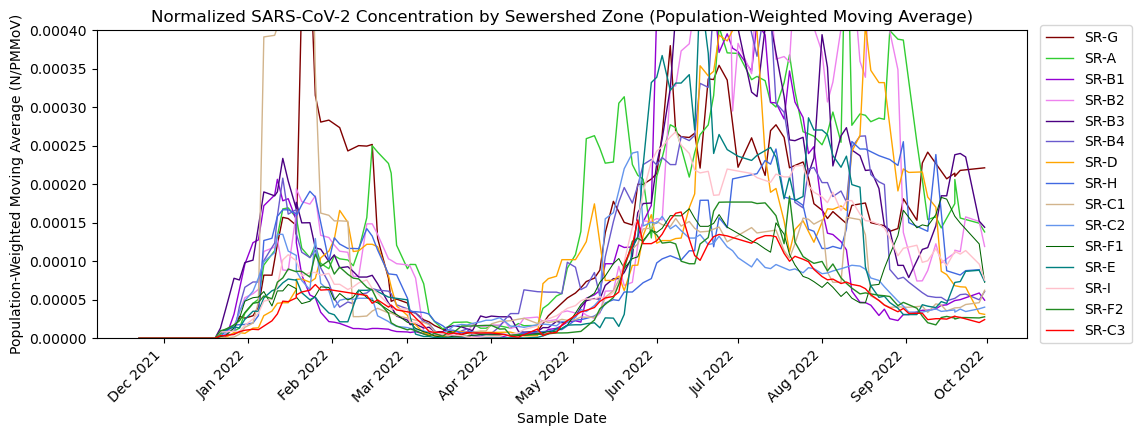

In [19]:
#plotting
plt.figure(figsize=(12,4))

plt.plot(SR_G_dates,SR_G_pma,c="maroon",linewidth=1,label="SR-G")
plt.plot(SR_A_dates,SR_A_pma,c="limegreen",linewidth=1,label="SR-A")
plt.plot(SR_B_1_dates,SR_B_1_pma,c="darkviolet",linewidth=1,label="SR-B1")
plt.plot(SR_B_2_dates,SR_B_2_pma,c="violet",linewidth=1,label="SR-B2")
plt.plot(SR_B_3_dates,SR_B_3_pma,c="indigo",linewidth=1,label="SR-B3")
plt.plot(SR_B_4_dates,SR_B_4_pma,c="slateblue",linewidth=1,label="SR-B4")
plt.plot(SR_D_dates,SR_D_pma,c="orange",linewidth=1,label="SR-D")
plt.plot(SR_H_dates,SR_H_pma,c="royalblue",linewidth=1,label="SR-H")
plt.plot(SR_C_1_dates,SR_C_1_pma,c="tan",linewidth=1,label="SR-C1")
plt.plot(SR_C_2_dates,SR_C_2_pma,c="cornflowerblue",linewidth=1,label="SR-C2")
plt.plot(SR_F_1_dates,SR_F_1_pma,c="darkgreen",linewidth=0.75,label="SR-F1")
plt.plot(SR_E_dates,SR_E_pma,c="teal",linewidth=1,label="SR-E")
plt.plot(SR_I_dates,SR_I_pma,c="pink",linewidth=1,label="SR-I")
plt.plot(SR_F_2_dates,SR_F_2_pma,c="forestgreen",linewidth=1,label="SR-F2")
plt.plot(SR_C_3_dates,SR_C_3_pma,c="red",linewidth=1,label="SR-C3")

#formatting
plt.title("Normalized SARS-CoV-2 Concentration by Sewershed Zone (Population-Weighted Moving Average)")
plt.xlabel("Sample Date")
plt.ylabel("Population-Weighted Moving Average (N/PMMoV)")
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.12,0.5), loc="right")
plt.ylim(0,0.0004)

#plt.show()

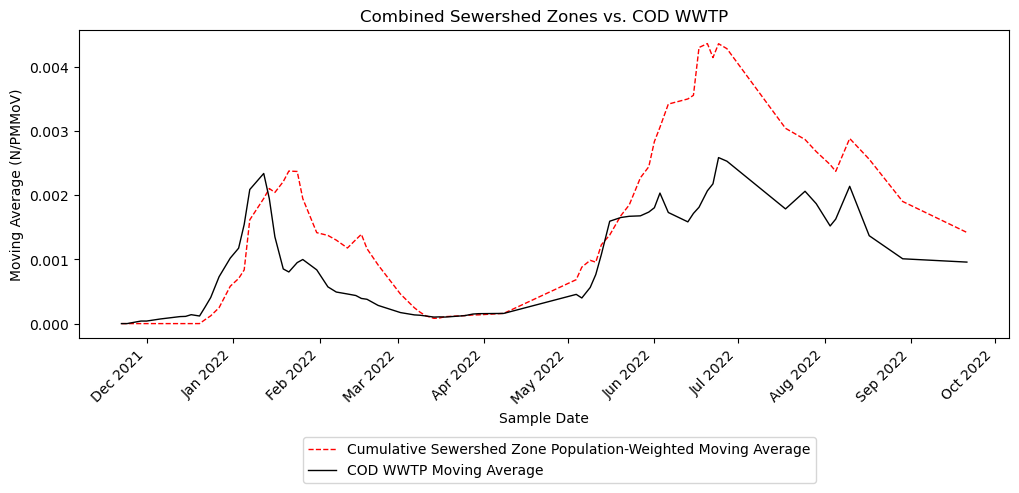

In [20]:
#Filtering for all points with shared x-values, didn't include Rancho Yolo/Research Park because the entire zone is overlapped
shared_x = sorted(list(set.intersection(*map(set, [SR_G_dates, SR_A_dates,SR_B_1_dates,
                                           SR_B_2_dates,SR_B_3_dates,SR_B_4_dates,SR_D_dates,
                                           SR_H_dates,SR_C_1_dates,SR_C_2_dates,
                                           SR_F_1_dates,SR_E_dates,SR_I_dates,
                                           SR_F_2_dates,COD_WWTP_dates]))))

shared_x = pd.to_datetime(pd.Series(shared_x), format='%Y-%m-%d')

FilteredPMA_SR_G = CumuPMA_SR_G[CumuPMA_SR_G['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_A = CumuPMA_SR_A[CumuPMA_SR_A['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_B_1 = CumuPMA_SR_B_1[CumuPMA_SR_B_1['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_B_2 = CumuPMA_SR_B_2[CumuPMA_SR_B_2['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_B_3 = CumuPMA_SR_B_3[CumuPMA_SR_B_3['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_B_4 = CumuPMA_SR_B_4[CumuPMA_SR_B_4['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_D = CumuPMA_SR_D[CumuPMA_SR_D['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_H = CumuPMA_SR_H[CumuPMA_SR_H['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_C_1 = CumuPMA_SR_C_1[CumuPMA_SR_C_1['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_C_2 = CumuPMA_SR_C_2[CumuPMA_SR_C_2['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_F_1 = CumuPMA_SR_F_1[CumuPMA_SR_F_1['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_E = CumuPMA_SR_E[CumuPMA_SR_E['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_I = CumuPMA_SR_I[CumuPMA_SR_I['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_F_2 = CumuPMA_SR_F_2[CumuPMA_SR_F_2['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]


FilteredMA_COD_WWTP = CumuMA_COD_WWTP[CumuMA_COD_WWTP['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["MA"]
FilteredPMA_COD_WWTP = CumuPMA_COD_WWTP[CumuPMA_COD_WWTP['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]

#Create a dataframe with all the values, then sum them, have two columns: cumulative and COD WWTP
filtered_pmas = [FilteredPMA_SR_G,FilteredPMA_SR_A,FilteredPMA_SR_B_1,FilteredPMA_SR_B_2,FilteredPMA_SR_B_3,FilteredPMA_SR_B_4,
                 FilteredPMA_SR_D,FilteredPMA_SR_H,FilteredPMA_SR_C_1,FilteredPMA_SR_C_2, FilteredPMA_SR_F_1,FilteredPMA_SR_E,FilteredPMA_SR_I,
                 FilteredPMA_SR_F_2]

cumu_pma = [sum(x) for x in zip(*filtered_pmas)]

cod_comparison = pd.DataFrame(list(zip(cumu_pma,FilteredMA_COD_WWTP)))
cod_comparison.columns = ["Cumulative Population-Weighted Moving Average","COD WWTP Moving Average"]
cod_comparison

#plotting comparison summary
plt.figure(figsize=(12,4))
plt.plot(shared_x,cumu_pma,c="red",linewidth=1,linestyle='dashed',label="Cumulative Sewershed Zone Population-Weighted Moving Average")
plt.plot(shared_x,FilteredMA_COD_WWTP,c="black",linewidth=1,label="COD WWTP Moving Average")

#formatting
plt.title("Combined Sewershed Zones vs. COD WWTP")
plt.xlabel("Sample Date")
plt.ylabel("Moving Average (N/PMMoV)")
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(0.8,-0.3))
#plt.ylim(0,0.0004)
plt.show()

In [21]:
from scipy.stats import spearmanr
corr_overall = spearmanr(cumu_pma, FilteredMA_COD_WWTP)
corr_overall

SpearmanrResult(correlation=0.904736156257314, pvalue=2.820948715109458e-27)

In [22]:
#Error propagation, since we are adding up values with errors
error_cumupma = np.sqrt(error_SR_G**2+error_SR_A**2+error_SR_B_1**2+error_SR_B_2**2+error_SR_B_3**2+error_SR_B_4**2+error_SR_D**2+error_SR_H**2+error_SR_C_1**2+error_SR_C_2**2+error_SR_F_1**2+error_SR_E**2+error_SR_I**2+error_SR_F_2**2)
error_CODWWTP = sum(abs(np.subtract(sewershed_zones["Raw Data"][0],COD_WWTP_pma)))/len(sewershed_zones["Raw Data"][0])
error_CODWWTP

0.0003600202426174497

In [23]:
pmas = [SR_G_pma,SR_A_pma,SR_B_1_pma,
        SR_B_2_pma,SR_B_3_pma,SR_B_4_pma,
        SR_D_pma,SR_H_pma,SR_C_1_pma,
        SR_C_2_pma,SR_F_1_pma,SR_E_pma,
        SR_I_pma,SR_F_2_pma,SR_C_3_pma]

FilteredPMA_SR_G = CumuPMA_SR_G[CumuPMA_SR_G['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_A = CumuPMA_SR_A[CumuPMA_SR_A['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_B_1 = CumuPMA_SR_B_1[CumuPMA_SR_B_1['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_B_2 = CumuPMA_SR_B_2[CumuPMA_SR_B_2['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_B_3 = CumuPMA_SR_B_3[CumuPMA_SR_B_3['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_B_4 = CumuPMA_SR_B_4[CumuPMA_SR_B_4['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_D = CumuPMA_SR_D[CumuPMA_SR_D['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_H = CumuPMA_SR_H[CumuPMA_SR_H['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_C_1 = CumuPMA_SR_C_1[CumuPMA_SR_C_1['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_C_2 = CumuPMA_SR_C_2[CumuPMA_SR_C_2['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_F_1 = CumuPMA_SR_F_1[CumuPMA_SR_F_1['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_E = CumuPMA_SR_E[CumuPMA_SR_E['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_I = CumuPMA_SR_I[CumuPMA_SR_I['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]
FilteredPMA_SR_F_2 = CumuPMA_SR_F_2[CumuPMA_SR_F_2['Sample Date'].isin(shared_x)].drop_duplicates(subset=['Sample Date'])["PMA"]

corr_SR_G = spearmanr(FilteredPMA_SR_G, FilteredMA_COD_WWTP)
corr_SR_A = spearmanr(FilteredPMA_SR_A, FilteredMA_COD_WWTP)
corr_SR_B_1 = spearmanr(FilteredPMA_SR_B_1, FilteredMA_COD_WWTP)
corr_SR_B_2 = spearmanr(FilteredPMA_SR_B_2, FilteredMA_COD_WWTP)
corr_SR_B_3 = spearmanr(FilteredPMA_SR_B_3, FilteredMA_COD_WWTP)
corr_SR_B_4 = spearmanr(FilteredPMA_SR_B_4, FilteredMA_COD_WWTP)
corr_SR_D = spearmanr(FilteredPMA_SR_D, FilteredMA_COD_WWTP)
corr_SR_H = spearmanr(FilteredPMA_SR_H, FilteredMA_COD_WWTP)
corr_SR_C_1 = spearmanr(FilteredPMA_SR_C_1, FilteredMA_COD_WWTP)
corr_SR_C_2 = spearmanr(FilteredPMA_SR_C_2, FilteredMA_COD_WWTP)
corr_SR_F_1 = spearmanr(FilteredPMA_SR_F_1, FilteredMA_COD_WWTP)
corr_SR_E = spearmanr(FilteredPMA_SR_E, FilteredMA_COD_WWTP)
corr_SR_I = spearmanr(FilteredPMA_SR_I, FilteredMA_COD_WWTP)
corr_SR_F_2 = spearmanr(FilteredPMA_SR_F_2, FilteredMA_COD_WWTP)

indiv_correlations = [corr_SR_G[0],corr_SR_A[0],corr_SR_B_1[0],
                      corr_SR_B_2[0],corr_SR_B_3[0],corr_SR_B_4[0],
                      corr_SR_D[0],corr_SR_H[0],corr_SR_C_1[0],corr_SR_C_2[0],
                      corr_SR_F_1[0],corr_SR_E[0],corr_SR_I[0],corr_SR_F_2[0]]

pvals = [corr_SR_G[1],corr_SR_A[1],corr_SR_B_1[1],
         corr_SR_B_2[1],corr_SR_B_3[1],corr_SR_B_4[1],
         corr_SR_D[1],corr_SR_H[1],corr_SR_C_1[1],corr_SR_C_2[1],
         corr_SR_F_1[1],corr_SR_E[1],corr_SR_I[1],corr_SR_F_2[1]]

zones = sewershed_zone_names[1:15]

zones
indiv_corr_table = pd.DataFrame(list(zip(zones,indiv_correlations,pvals)))
indiv_corr_table.columns = ["Name","Correlation","P-Value"]
pd.set_option("display.precision", 3)
indiv_corr_table

,Name,Correlation,P-Value
0,SR-G,0.738,2.199e-13
1,SR-A,0.770,4.188e-15
2,SR-B1,0.935,8.260e-33
3,SR-B2,0.836,1.237e-19
4,SR-B3,0.927,4.695e-31
5,SR-B4,0.922,3.263e-30
6,SR-D,0.734,3.151e-13
7,SR-H,0.732,3.880e-13
8,SR-C1,0.793,1.692e-16
9,SR-C2,0.890,3.218e-25


In [25]:
#Total population captured by the sampling regime
city_zone_pops = sum([12389,7936,15920,1324,1794,3920,5935,3696,10912]) #sub-sewershed zone populations
total_city_pop = 66850 #according to census
city_zone_pops/total_city_pop*100

95.47643979057592

In [26]:
#Percent of >65-year-old subgroup population represented
tot_above65 = sum(Above65_sewershed_zone_proportions["Manually Derived Population Above 65 Years Represented"])
prob_rep = sum(Above65_sewershed_zone_proportions["Probabilistically Assigned Population Above 65 Years Represented"])
prob_rep/tot_above65*100

86.93838125943189